# Tutorial 2: Stop detection in trajectories

This notebook shows how to process device-level trajectory data, in different formats, to detect stops using ```nomad```. Stop detection is an important step in
pre-processing trajectory data and in making sense of trajectories by grouping together pings that reflect stationary behavior. The output of stop-detection algorithms is commonly a "stop table", indicating when a stop started, its duration, and a pair of coordinates that approximates the location of the group of pings (typically the centroid). Alternatively, ```nomad``` allows users to retrieve a cluster label for each ping (useful for plotting, for example)

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), "..")))

In [1]:
import filters
import daphmeIO as loader
import constants as constants
import stop_detection as SD

ModuleNotFoundError: No module named 'filters'

In [58]:
import pandas as pd
from scipy.spatial.distance import pdist, cdist
import numpy as np
import math
import datetime as dt
from datetime import timedelta
import matplotlib.pyplot as plt
import itertools
from collections import defaultdict
import sys
import os
import pdb

## Load data sample

For these examples we load some test data from ```nomad``` which has the following trajectory columns (notice that ```traj_cols``` maps the data's column names to default names used by ```nomad```)

In [59]:
traj_cols = {'user_id':'user_id',
             'latitude':'dev_lat',
             'longitude':'dev_lon',
             'datetime':'local_datetime'}

In [60]:
path = '../data/sample4/'
data = loader.from_file(path, traj_cols=traj_cols, format='csv')

This synthetic data has records for 100 users for a 1 week period, with spherical coordinates (lat, lon) and datetime format for the time component of each ping. 

In [61]:
data.head()

,user_id,dev_lat,dev_lon,local_datetime
0,wizardly_joliot,38.321711,-36.667334,2024-01-01 14:29:00
1,wizardly_joliot,38.321676,-36.667365,2024-01-01 14:35:00
2,wonderful_swirles,38.321017,-36.667869,2024-01-01 15:06:00
3,youthful_galileo,38.321625,-36.666612,2024-01-01 08:47:00
4,youthful_galileo,38.321681,-36.666841,2024-01-01 09:59:00


## Stop detection algorithms

The stop detection algorithms in ```nomad``` are applied to each user's trajectories separately. Thus, we demonstrate first by sampling a single user's data.

In [62]:
user_sample = data.loc[data.user_id == "angry_spence"]

In [63]:
user_sample.head()

,user_id,dev_lat,dev_lon,local_datetime
991,angry_spence,38.320990,-36.666555,2024-01-01 10:21:00
992,angry_spence,38.320962,-36.666504,2024-01-01 10:27:00
993,angry_spence,38.320955,-36.666495,2024-01-01 10:29:00
994,angry_spence,38.320947,-36.666521,2024-01-01 10:39:00
995,angry_spence,38.320955,-36.666527,2024-01-01 10:42:00


For this user, the trajectory data has 1696 rows (pings) and covers a period of 15 days (start date: 2024-01-01, end date: 2024-01-15). We can visualize the trajectory for one day below: 

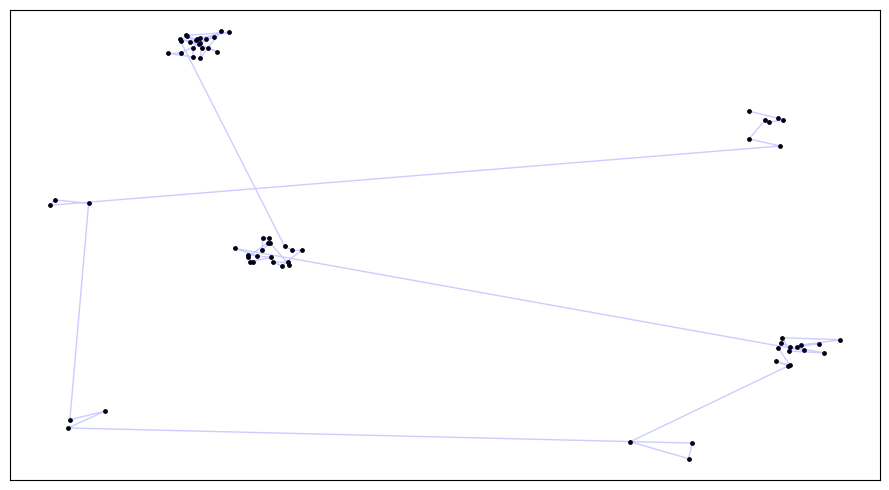

In [64]:
plot_data = user_sample[user_sample['local_datetime'].dt.date == pd.to_datetime('2024-01-01').date()]

fig, ax = plt.subplots(figsize=(9, 5))

ax.scatter(x=plot_data['dev_lon'], 
           y=plot_data['dev_lat'],
           s=6,
           color='black',
           alpha=1,
           zorder=2)

ax.plot(plot_data['dev_lon'],
        plot_data['dev_lat'],
        linewidth=1, color='blue', alpha=0.2)

ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticks([])

plt.tight_layout()
plt.show()

### Sequential stop detection (Lachesis)

The first stop detection algorithm implemented in ```nomad``` is a sequential algorithm described in "Project Lachesis: Parsing and Modeling Location Histories". This algorithm for extracting stays is dependent on two parameters: the roaming distance and the stay duration. Roaming distance represents the maximum distance an object can move away from a point location and still be considered to be staying at that location. Stay duration is the minimum amount of time an object must spend within the roaming distance of a location to qualify as a stay. The algorithm identifies contiguous sequences of raw location data points that stay within the roaming distance for at least the duration of the stay duration

This algorithm has the following parameters, which determine the size of the resulting stops:
* ```dur_min```: Minimum duration for a stay in minutes.
* ```dt_max```: Maximum time gap permitted between consecutive pings in a stay in minutes (dt_max should be greater than dur_min).
* ```delta_roam```: Maximum roaming distance for a stay in meters.

In [65]:
DUR_MIN = 60
DT_MAX = 120
DELTA_ROAM = 50

The Lachesis algorithm can output a complete table of attributes for identified stops, including the start time, end time, the medoid coordinates, duration, number of pings in the stop, and diameter.

In [66]:
%%time
SD.lachesis(traj=user_sample, dur_min=DUR_MIN, dt_max=DT_MAX, delta_roam=DELTA_ROAM, traj_cols=traj_cols, complete_output=True).head()

CPU times: user 270 ms, sys: 7.36 ms, total: 277 ms
Wall time: 278 ms


,start_time,end_time,dev_lon,dev_lat,diameter,n_pings,duration
0,2024-01-01 15:04:00,2024-01-01 16:16:00,-36.66647,38.320064,14.691535,14,72.0
1,2024-01-01 18:17:00,2024-01-01 20:58:00,-36.667398,38.320415,12.974932,19,161.0
2,2024-01-01 21:15:00,2024-01-02 01:10:00,-36.667525,38.321253,13.946715,32,235.0
3,2024-01-02 05:54:00,2024-01-02 08:01:00,-36.667489,38.321273,31.46013,17,127.0
4,2024-01-02 08:40:00,2024-01-02 11:59:00,-36.667721,38.320554,20.736412,39,199.0


An additional argument, ```complete_output```, can be passed to only output the stop start time, duration, and medoid coordinates.

In [67]:
%%time
SD.lachesis(traj=user_sample, dur_min=DUR_MIN, dt_max=DT_MAX, delta_roam=DELTA_ROAM, traj_cols=traj_cols, complete_output=False).head()

CPU times: user 275 ms, sys: 4.97 ms, total: 280 ms
Wall time: 277 ms


,start_time,duration,dev_lon,dev_lat
0,2024-01-01 15:04:00,72.0,-36.66647,38.320064
1,2024-01-01 18:17:00,161.0,-36.667398,38.320415
2,2024-01-01 21:15:00,235.0,-36.667525,38.321253
3,2024-01-02 05:54:00,127.0,-36.667489,38.321273
4,2024-01-02 08:40:00,199.0,-36.667721,38.320554


We can also get the final cluster label for each of the pings, including those who were identified as noise.

In [68]:
%%time
SD._lachesis_labels(traj=user_sample, dur_min=DUR_MIN, dt_max=DT_MAX, delta_roam=DELTA_ROAM, traj_cols=traj_cols).head()

CPU times: user 298 ms, sys: 11.7 ms, total: 310 ms
Wall time: 441 ms


,cluster
2024-01-01 10:21:00,-1
2024-01-01 10:27:00,-1
2024-01-01 10:29:00,-1
2024-01-01 10:39:00,-1
2024-01-01 10:42:00,-1


The data could also come with different formats for spatial and temporal variables, the algorithm can handle those situations as well.

In [69]:
%%time
# x, y, timestamp (unix time)
traj_cols_x_y_timestamp = {'user_id':'user_id',
                          'x':'x',
                          'y':'y',
                          'timestamp':'unix_time'}

user_sample_x_y_timestamp = user_sample.copy()
user_sample_x_y_timestamp = filters.to_projection(user_sample_x_y_timestamp, longitude='dev_lon', latitude='dev_lat')
user_sample_x_y_timestamp['unix_time'] = user_sample_x_y_timestamp['local_datetime'].astype('int64') // 10**9

# Lachesis with x, y, and timestamp (unix time)
SD.lachesis(user_sample_x_y_timestamp, DUR_MIN, DT_MAX, DELTA_ROAM, traj_cols=traj_cols_x_y_timestamp, complete_output=False).head()

CPU times: user 94.9 ms, sys: 4.91 ms, total: 99.8 ms
Wall time: 99.2 ms


,start_time,duration,x,y
0,1.704121e+09,72.0,-4.081693e+06,4.624739e+06
1,1.704133e+09,161.0,-4.081796e+06,4.624789e+06
2,1.704144e+09,235.0,-4.081810e+06,4.624908e+06
3,1.704175e+09,127.0,-4.081806e+06,4.624911e+06
4,1.704185e+09,199.0,-4.081832e+06,4.624809e+06


### Density based stop detection (Temporal DBSCAN)

The second stop detection algorithm implemented in ```nomad``` is a density-based algorithm with time-constraints, Temporal DBSCAN. 

This algorithm for clustering user pings combines temporal and spatial dimensions, relying on three key parameters: the time threshold, the distance threshold, and the minimum number of points. The time threshold defines the maximum time difference (in minutes) between two consecutive pings for them to be considered neighbors within the same cluster. The distance threshold specifies the maximum spatial distance (in meters) between two pings for them to be considered neighbors. The minimum points parameter sets the minimum number of points required for a dense region to form a cluster. If a region contains fewer than minimum number of points required, it is treated as noise. The algorithm identifies clusters by grouping contiguous pings that meet both the temporal and spatial criteria, while also ensuring that each cluster has enough density to be considered valid.

This algorithm has the following parameters, which determine the size of the resulting stops:
* ```time_thresh```: Time threshold in minutes for identifying neighbors.
* ```dist_thresh```: Distance threshold in meters for identifying neighbors.
* ```min_pts```: Minimum number of points required to form a dense region (core point).

In [85]:
TIME_THRESH = 100
DIST_THRESH = 40
MIN_PTS = 10

Similarly to Lachesis, the Temporal DBSCAN algorithm can output a complete table of attributes for identified stops, including the start time, end time, the medoid coordinates, duration, number of pings in the stop, and diameter.

In [71]:
%%time
SD.temporal_dbscan(user_sample, TIME_THRESH, DIST_THRESH, MIN_PTS, traj_cols=traj_cols, complete_output=True).head()

CPU times: user 13 s, sys: 588 ms, total: 13.6 s
Wall time: 14 s


,start_time,end_time,dev_lon,dev_lat,diameter,n_pings,duration
cluster,,,,,,,
0,2024-01-04 16:02:00,2024-01-04 16:45:00,-0.639973,0.668841,11.374422,14,43.0
1,2024-01-14 19:45:00,2024-01-15 07:39:00,-0.639968,0.668818,22.775558,87,714.0
2,2024-01-14 14:10:00,2024-01-14 15:39:00,-0.639963,0.668810,14.062991,13,89.0
3,2024-01-14 01:45:00,2024-01-14 07:52:00,-0.639956,0.668827,13.814779,57,367.0
4,2024-01-13 13:53:00,2024-01-13 16:45:00,-0.639952,0.668824,61.588256,18,172.0


The additional argument ```complete_output``` can also be passed to only output the stop start time, duration, and medoid coordinates.

In [72]:
%%time
SD.temporal_dbscan(user_sample, TIME_THRESH, DIST_THRESH, MIN_PTS, traj_cols=traj_cols, complete_output=False).head()

CPU times: user 13 s, sys: 615 ms, total: 13.6 s
Wall time: 13.8 s


,start_time,duration,dev_lon,dev_lat
cluster,,,,
0,2024-01-04 16:02:00,43.0,-0.639973,0.668841
1,2024-01-14 19:45:00,714.0,-0.639968,0.668818
2,2024-01-14 14:10:00,89.0,-0.639963,0.668810
3,2024-01-14 01:45:00,367.0,-0.639956,0.668827
4,2024-01-13 13:53:00,172.0,-0.639952,0.668824


We can also get the final cluster and core labels for each of the pings.

In [73]:
%%time
SD._temporal_dbscan_labels(user_sample, TIME_THRESH, DIST_THRESH, MIN_PTS, traj_cols=traj_cols).head()

CPU times: user 12.9 s, sys: 586 ms, total: 13.5 s
Wall time: 13.5 s


,cluster,core
2024-01-01 10:21:00,-1,-1
2024-01-01 10:27:00,-1,-1
2024-01-01 10:29:00,-1,-1
2024-01-01 10:39:00,-1,-1
2024-01-01 10:42:00,-1,-1


The Temporal DBSCAN algorithm also handles data that comes with different formats for spatial and temporal variables.

In [74]:
%%time
SD.temporal_dbscan(user_sample_x_y_timestamp, TIME_THRESH, DIST_THRESH, MIN_PTS, traj_cols=traj_cols_x_y_timestamp, complete_output=False).head()

CPU times: user 3.52 s, sys: 631 ms, total: 4.15 s
Wall time: 4.51 s


,start_time,duration,x,y
cluster,,,,
0,1.704384e+09,43.0,-4.081836e+06,4.624984e+06
1,1.705262e+09,714.0,-4.081802e+06,4.624791e+06
2,1.705241e+09,89.0,-4.081771e+06,4.624728e+06
3,1.705197e+09,367.0,-4.081725e+06,4.624865e+06
4,1.705158e+09,99.0,-4.081703e+06,4.624845e+06
